In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data = pd.read_csv('../data/winequality-red.csv')

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [17]:
data.shape

(1599, 13)

In [4]:
data['quality'].value_counts().sort_index()

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [5]:
data['vinho_bom'] = data['quality'].map(lambda x: 0 if x < 7 else 1)

In [7]:
data['vinho_bom'].value_counts()

0    1382
1     217
Name: vinho_bom, dtype: int64

In [6]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,vinho_bom
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [10]:
from lightgbm import LGBMClassifier

In [12]:
from sklearn.model_selection import train_test_split

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data.iloc[:,:-2], data['vinho_bom'], train_size = 0.5)

In [16]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((799, 11), (800, 11), (799,), (800,))

In [20]:
Xtrain.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
273,8.4,0.715,0.20,2.4,0.076,10.0,38.0,0.99735,3.31,0.64,9.4
809,7.6,0.480,0.31,2.8,0.070,4.0,15.0,0.99693,3.22,0.55,10.3
689,8.1,0.380,0.48,1.8,0.157,5.0,17.0,0.99760,3.30,1.05,9.4
881,7.6,0.715,0.00,2.1,0.068,30.0,35.0,0.99533,3.48,0.65,11.4
759,8.8,0.420,0.21,2.5,0.092,33.0,88.0,0.99823,3.19,0.52,9.2


In [28]:
model = LGBMClassifier(random_state=0)
model.fit(Xtrain, ytrain)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [29]:
from sklearn.metrics import roc_auc_score
p = model.predict_proba(Xtest)[:,1]

In [30]:
roc_auc_score(ytest, p)

0.8962201591511937

# Random Search 

In [22]:
from skopt import dummy_minimize

In [34]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params)
    
    model = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                           subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                           n_estimators=100)
    model.fit(Xtrain, ytrain)
    
    p = model.predict_proba(Xtest)[:,1]
    
    return -roc_auc_score(ytest, p)


space = [(1e-3, 1e-1, 'log-uniform'), # learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree


resultado = dummy_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0800
Function value obtained: -0.8816
Current minimum: -0.8816
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0350
Function value obtained: -0.8616
Current minimum: -0.8816
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0610
Function value obtained: -0.8814
Current minimum: -0.8816
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 

In [35]:
# melhores parâmetros obtidos
resultado.x

[0.021930881089764206, 73, 4, 0.6880713925510277, 0.47060909107214777]

In [36]:
# auc = 0.9045 - [0.021930881089764206, 73, 4, 0.6880713925510277, 0.47060909107214777]

# Bayesian Optimization

In [37]:
from skopt import gp_minimize

In [38]:
resultados_gp = gp_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 120, 14, 0.9990884895579377, 0.3124800792567785]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1360
Function value obtained: -0.9024
Current minimum: -0.9024
Iteration No: 2 started. Evaluating function at random point.
[0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0500
Function value obtained: -0.8703
Current minimum: -0.9024
Iteration No: 3 started. Evaluating function at random point.
[0.004232013397179603, 68, 45, 0.2680983530433343, 0.5809725180523154]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0390
Function value obtained: -0.8692
Current minimum: -0.9024
Iteration No: 4 started. Evaluating function at random point.
[0.0672858974212934, 60, 44, 0.9421713999524447, 0.8005503127028804]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0

# exploration exploitation tradeoff

In [49]:
resultados_gp.x

[0.09871192514273254, 120, 14, 0.9990884895579377, 0.3124800792567785]

In [47]:
from skopt.plots import plot_convergence

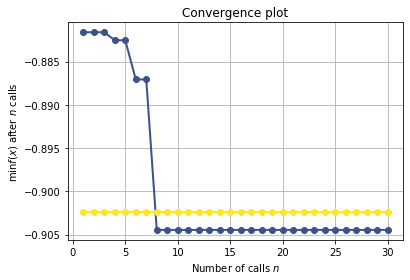

In [48]:
plot_convergence(resultado, resultados_gp);